# Celda 1 — Imports, semillas, hilos, rutas y utilidades

In [13]:
# ==== Imports base ====
import os, time, gc, itertools, json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# ==== Reproducibilidad ====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==== Control de hilos (Windows/CPU) para estabilidad ====
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

# ==== Rutas ====
DATA_DIR   = Path("../data/processed/seq")
REPORT_DIR = Path("../reports/models")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# util para tiempo bonito
def mmss(t):
    m = int(t // 60); s = int(t % 60)
    return f"{m:02d}:{s:02d}"


# Celda 2 — Carga de secuencias (de Cuaderno 4)

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

def _load_idx_any(path_npy: Path, path_csv: Path) -> pd.DatetimeIndex:
    """Carga índice de fechas desde .npy o .csv y lo devuelve como DatetimeIndex."""
    if path_npy.exists():
        arr = np.load(path_npy)  # puede venir como str o datetime64
        return pd.DatetimeIndex(arr)
    if path_csv.exists():
        df = pd.read_csv(path_csv)
        # intenta columnas típicas de fecha
        for col in ["Date", "date", "fecha", "idx", "index"]:
            if col in df.columns:
                return pd.DatetimeIndex(pd.to_datetime(df[col], utc=False))
        # si solo hay 1 columna, usa esa
        if df.shape[1] == 1:
            return pd.DatetimeIndex(pd.to_datetime(df.iloc[:, 0], utc=False))
        raise ValueError(f"No se encontró columna de fecha en {path_csv}")
    raise FileNotFoundError(f"Falta índice: {path_npy.name} / {path_csv.name}")

def load_seq(ticker: str, window: int):
    base = DATA_DIR / ticker / f"w{window}"

    # Arrays (estos sí son .npy)
    Xtr = np.load(base/"X_train.npy"); ytr = np.load(base/"y_train.npy")
    Xva = np.load(base/"X_val.npy");   yva = np.load(base/"y_val.npy")
    Xte = np.load(base/"X_test.npy");  yte = np.load(base/"y_test.npy")

    # Índices: intenta .npy y, si no, .csv
    idx_tr = _load_idx_any(base/"idx_train.npy", base/"idx_train.csv")
    idx_va = _load_idx_any(base/"idx_val.npy",   base/"idx_val.csv")
    idx_te = _load_idx_any(base/"idx_test.npy",  base/"idx_test.csv")

    # Meta
    meta_path = base/"meta.json"
    meta = json.load(open(meta_path, "r")) if meta_path.exists() else {
        "ticker": ticker, "window": window, "n_features": Xtr.shape[-1]
    }

    return (Xtr,ytr),(Xva,yva),(Xte,yte),meta



# Celda 3 — Baseline de persistencia (diagnóstico)

In [15]:
def naive_persistence(X3: np.ndarray) -> np.ndarray:
    """Devuelve el último Close de la ventana (asumimos Close como 1ª feature)."""
    return X3[:, -1, 0]

for tkr in ["BBVA","SAN"]:
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, 20)
    yhat_naive = naive_persistence(Xte)
    mse_naive = np.mean((yhat_naive - yte)**2)
    print(f"{tkr} · Naive (persistencia) · MSE test = {mse_naive:.6f}")


BBVA · Naive (persistencia) · MSE test = 0.012875
SAN · Naive (persistencia) · MSE test = 0.018460


# Celda 4 — Constructor de modelos (robusto y sin warning)

In [16]:
def build_model(model_type: str, units: int, n_features: int, window_size: int, lr: float) -> keras.Model:
    inp = keras.Input(shape=(window_size, n_features), name="seq")
    if model_type == "SimpleRNN":
        x = layers.SimpleRNN(units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1,
                             kernel_regularizer=regularizers.l2(1e-5))(inp)
        x = layers.SimpleRNN(units, dropout=0.1, recurrent_dropout=0.1)(x)
    elif model_type == "LSTM":
        x = layers.LSTM(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.LSTM(units, dropout=0.2, recurrent_dropout=0.2)(x)
    elif model_type == "GRU":
        x = layers.GRU(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.GRU(units, dropout=0.2, recurrent_dropout=0.2)(x)
    else:
        raise ValueError("model_type debe ser 'SimpleRNN', 'LSTM' o 'GRU'")
    out = layers.Dense(1, name="y")(x)

    model = keras.Model(inp, out, name=f"{model_type}_u{units}_w{window_size}")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mse"])
    return model


# Celda 5 — Callbacks de progreso y límite por combo

In [17]:
MAX_EPOCHS = 80     # puedes ajustar
PATIENCE   = 3       # EarlyStopping
MAX_SECS   = 30*60   # ⏱️ límite por combo (None para sin límite)

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.t0 = time.time()
    def on_epoch_begin(self, epoch, logs=None):
        print(f"    · epoch {epoch+1}/{self.params.get('epochs', '?')} ...", flush=True)
    def on_train_end(self, logs=None):
        print(f"    · done in {mmss(time.time()-self.t0)}", flush=True)

class StopAfterSeconds(keras.callbacks.Callback):
    def __init__(self, seconds=None):
        super().__init__(); self.seconds = seconds
    def on_train_begin(self, logs=None):
        self.t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        if self.seconds is not None and (time.time()-self.t0) > self.seconds:
            print("    ⏱️  Paro por tiempo máximo de combo", flush=True)
            self.model.stop_training = True


# Celda 6 — Entrenar con logs + evaluar (sustituye a fit_and_eval)

In [18]:
def fit_and_eval_with_logs(model_type, tkr, W, units, batch, lr, epochs=MAX_EPOCHS):
    # Datos
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, W)
    n_features = meta["n_features"]

    # Modelo
    model = build_model(model_type, units, n_features, W, lr)

    # Datasets tf.data (más estables en memoria)
    ds_tr = tf.data.Dataset.from_tensor_slices((Xtr, ytr)).batch(batch).cache().prefetch(tf.data.AUTOTUNE)
    ds_va = tf.data.Dataset.from_tensor_slices((Xva, yva)).batch(batch)
    ds_te = tf.data.Dataset.from_tensor_slices((Xte, yte)).batch(batch)

    # Callbacks
    cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
           TimeHistory(),
           StopAfterSeconds(MAX_SECS)]

    # Entrenamiento
    h = model.fit(ds_tr, validation_data=ds_va, epochs=epochs, verbose=0, callbacks=cbs)

    # Evaluación
    y_pred_va = model.predict(ds_va, verbose=0).ravel()
    y_pred_te = model.predict(ds_te, verbose=0).ravel()
    val_mse = float(np.mean((y_pred_va - yva)**2))
    test_mse = float(np.mean((y_pred_te - yte)**2))

    # Limpieza memoria
    keras.backend.clear_session(); del model
    gc.collect()

    return {"val_mse": val_mse, "test_mse": test_mse}


# Celda 7 — Configuración del grid (con recorte SAN·LSTM)

In [19]:
TICKERS = ["BBVA", "SAN"]
MODELS  = ["SimpleRNN", "LSTM", "GRU"]

GRID = {
    "window": [10,20,30],
    "units":  [32,64,128],
    "batch":  [32,64],
    "lr":     [1e-3, 5e-4],
}

def grid_for(ticker, model):
    g = {k: v[:] for k, v in GRID.items()}
    # ⚠️ Cuello típico: SAN · LSTM — lo recortamos para no atascar
    if ticker == "SAN" and model == "LSTM":
        g["window"] = [20,30]
        g["units"]  = [64,128]
        g["batch"]  = [32]   # quita 64 para evitar swap
    return g


# Celda 8 — (Opcional) Curvas de pérdida rápidas (5/7/10 epochs)

# Celda 9 — Grid Search con progreso, guardado incremental y reanudación

In [20]:
OUT_DIR = REPORT_DIR
OUT_DIR.mkdir(parents=True, exist_ok=True)

def grid_search_for_model(tkr: str, model_type: str) -> pd.DataFrame:
    partial_csv = OUT_DIR / f"grid_partial_{tkr}_{model_type}.csv"
    rows = []

    # Reanudación si existe parcial
    if partial_csv.exists():
        prev = pd.read_csv(partial_csv)
        rows = prev.to_dict("records")
        print(f"⏭️  Reanudando: {len(rows)} combos ya terminados")

    done = {(r["window"], r["units"], r["batch"], float(r["lr"])) for r in rows}
    g = grid_for(tkr, model_type)
    combos = list(itertools.product(g["window"], g["units"], g["batch"], g["lr"]))
    total = len(combos)

    for i, (W, U, B, LR) in enumerate(combos, start=1):
        if (W,U,B,float(LR)) in done:
            print(f"⏭️  {tkr} · {model_type} · combo {i}/{total} (W={W},U={U},B={B},lr={LR}) ya estaba")
            continue

        print(f"\n▶ {tkr} · {model_type} · combo {i}/{total}  (W={W}, U={U}, B={B}, lr={LR})")
        t0 = time.time()
        try:
            res = fit_and_eval_with_logs(model_type, tkr, W, units=U, batch=B, lr=LR, epochs=MAX_EPOCHS)
            status = "ok"
        except Exception as e:
            print(f"    ⚠️  Error: {type(e).__name__}: {e}")
            res = {"val_mse": np.nan, "test_mse": np.nan}
            status = f"error:{type(e).__name__}"

        dt = time.time() - t0
        print(f"    ↳ val_mse={res['val_mse']:.6f} · test_mse={res['test_mse']:.6f} · {mmss(dt)}")

        rows.append({
            "ticker": tkr, "model": model_type,
            "window": W, "units": U, "batch": B, "lr": LR,
            "val_mse": res["val_mse"], "test_mse": res["test_mse"],
            "secs": round(dt,1), "status": status
        })
        pd.DataFrame(rows).to_csv(partial_csv, index=False)

        time.sleep(0.2)  # respiro
        gc.collect()

    df_rank = pd.DataFrame(rows).sort_values(["val_mse","test_mse"], na_position="last").reset_index(drop=True)
    return df_rank

all_ranks = []
for tkr in TICKERS:
    for m in MODELS:
        print(f"\n==== Grid Search: {tkr} · {m} ====")
        rank_df = grid_search_for_model(tkr, m)
        rank_df.to_csv(OUT_DIR / f"grid_{tkr}_{m}.csv", index=False)
        all_ranks.append(rank_df.assign(order=range(1, len(rank_df)+1)))

grid_all = pd.concat(all_ranks, ignore_index=True)
grid_all.head()



==== Grid Search: BBVA · SimpleRNN ====
⏭️  Reanudando: 5 combos ya terminados
⏭️  BBVA · SimpleRNN · combo 1/36 (W=10,U=32,B=32,lr=0.001) ya estaba
⏭️  BBVA · SimpleRNN · combo 2/36 (W=10,U=32,B=32,lr=0.0005) ya estaba
⏭️  BBVA · SimpleRNN · combo 3/36 (W=10,U=32,B=64,lr=0.001) ya estaba
⏭️  BBVA · SimpleRNN · combo 4/36 (W=10,U=32,B=64,lr=0.0005) ya estaba
⏭️  BBVA · SimpleRNN · combo 5/36 (W=10,U=64,B=32,lr=0.001) ya estaba

▶ BBVA · SimpleRNN · combo 6/36  (W=10, U=64, B=32, lr=0.0005)
    · epoch 1/80 ...
    · epoch 2/80 ...
    · epoch 3/80 ...
    · epoch 4/80 ...
    · epoch 5/80 ...
    · epoch 6/80 ...
    · epoch 7/80 ...
    · epoch 8/80 ...
    · epoch 9/80 ...
    · done in 00:09
    ↳ val_mse=0.004908 · test_mse=0.030857 · 00:10

▶ BBVA · SimpleRNN · combo 7/36  (W=10, U=64, B=64, lr=0.001)
    · epoch 1/80 ...
    · epoch 2/80 ...
    · epoch 3/80 ...
    · epoch 4/80 ...
    · epoch 5/80 ...
    · epoch 6/80 ...
    · epoch 7/80 ...
    · epoch 8/80 ...
    · epoch 9

,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,SimpleRNN,20,64,32,0.0010,0.000294,0.014740,21.2,ok,2
2,BBVA,SimpleRNN,20,64,64,0.0010,0.000302,0.003813,14.1,ok,3
3,BBVA,SimpleRNN,30,64,32,0.0005,0.000321,0.010423,26.9,ok,4
4,BBVA,SimpleRNN,20,64,64,0.0005,0.000377,0.007117,15.6,ok,5


# Celda 10 — Top-10 por ticker/modelo y resumen “mejor de cada uno”

In [21]:
# Top-10 por grupo
tops = []
for tkr in TICKERS:
    for m in MODELS:
        dfm = grid_all[(grid_all["ticker"]==tkr) & (grid_all["model"]==m)].sort_values(["val_mse","test_mse"]).head(10)
        dfm.to_csv(OUT_DIR / f"top10_{tkr}_{m}.csv", index=False)
        print(f"\n=== {tkr} · {m} — Top-10 (por val_mse) ===")
        display(dfm)
        tops.append(dfm.assign(kind=f"{tkr}_{m}"))

top_all = pd.concat(tops, ignore_index=True)
top_all.to_csv(OUT_DIR / "top10_all.csv", index=False)

# Mejor de cada grupo
best_rows = []
for t in TICKERS:
    for m in MODELS:
        best_rows.append(grid_all[(grid_all.ticker==t)&(grid_all.model==m)].sort_values(["val_mse","test_mse"]).iloc[0])
best_table = pd.DataFrame(best_rows).reset_index(drop=True)
best_table.to_csv(OUT_DIR / "best_models_summary.csv", index=False)
display(best_table)
print("✅ Guardado resumen:", OUT_DIR / "best_models_summary.csv")



=== BBVA · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,SimpleRNN,20,64,32,0.0010,0.000294,0.014740,21.2,ok,2
2,BBVA,SimpleRNN,20,64,64,0.0010,0.000302,0.003813,14.1,ok,3
3,BBVA,SimpleRNN,30,64,32,0.0005,0.000321,0.010423,26.9,ok,4
4,BBVA,SimpleRNN,20,64,64,0.0005,0.000377,0.007117,15.6,ok,5
5,BBVA,SimpleRNN,30,64,32,0.0010,0.000412,0.014149,29.3,ok,6
6,BBVA,SimpleRNN,30,32,64,0.0010,0.000452,0.001529,18.4,ok,7
7,BBVA,SimpleRNN,20,32,32,0.0005,0.000542,0.006686,23.6,ok,8
8,BBVA,SimpleRNN,20,128,64,0.0010,0.000568,0.009461,15.7,ok,9
9,BBVA,SimpleRNN,10,64,64,0.0005,0.000724,0.002620,8.8,ok,10



=== BBVA · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
36,BBVA,LSTM,10,128,32,0.0005,0.000278,0.000864,NaN,NaN,1
37,BBVA,LSTM,30,128,32,0.0010,0.000287,0.000829,NaN,NaN,2
38,BBVA,LSTM,20,64,64,0.0005,0.000295,0.000814,NaN,NaN,3
39,BBVA,LSTM,30,128,64,0.0005,0.000300,0.000892,NaN,NaN,4
40,BBVA,LSTM,20,32,64,0.0010,0.000310,0.001142,NaN,NaN,5
41,BBVA,LSTM,10,128,64,0.0010,0.000322,0.000839,NaN,NaN,6
42,BBVA,LSTM,20,32,32,0.0010,0.000324,0.001180,NaN,NaN,7
43,BBVA,LSTM,20,128,32,0.0005,0.000332,0.000817,NaN,NaN,8
44,BBVA,LSTM,20,128,64,0.0005,0.000335,0.000847,NaN,NaN,9
45,BBVA,LSTM,10,64,32,0.0010,0.000335,0.000751,NaN,NaN,10



=== BBVA · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
72,BBVA,GRU,10,128,32,0.0005,0.000224,0.000654,NaN,NaN,1
73,BBVA,GRU,20,128,64,0.0005,0.000254,0.000641,NaN,NaN,2
74,BBVA,GRU,10,64,32,0.0005,0.000259,0.000927,NaN,NaN,3
75,BBVA,GRU,20,64,64,0.0010,0.000290,0.000658,NaN,NaN,4
76,BBVA,GRU,30,32,64,0.0005,0.000291,0.001006,NaN,NaN,5
77,BBVA,GRU,30,64,64,0.0010,0.000293,0.001049,NaN,NaN,6
78,BBVA,GRU,20,32,64,0.0010,0.000298,0.000795,NaN,NaN,7
79,BBVA,GRU,10,32,32,0.0005,0.000310,0.001078,NaN,NaN,8
80,BBVA,GRU,10,64,64,0.0005,0.000317,0.000986,NaN,NaN,9
81,BBVA,GRU,10,64,32,0.0010,0.000319,0.000920,NaN,NaN,10



=== SAN · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
108,SAN,SimpleRNN,20,32,64,0.0010,0.000430,0.000614,NaN,NaN,1
109,SAN,SimpleRNN,20,128,64,0.0010,0.000482,0.000566,NaN,NaN,2
110,SAN,SimpleRNN,20,64,32,0.0005,0.000485,0.000517,NaN,NaN,3
111,SAN,SimpleRNN,30,64,64,0.0010,0.000486,0.000493,NaN,NaN,4
112,SAN,SimpleRNN,20,64,32,0.0010,0.000509,0.002873,NaN,NaN,5
113,SAN,SimpleRNN,30,128,32,0.0005,0.000514,0.000770,NaN,NaN,6
114,SAN,SimpleRNN,20,128,32,0.0005,0.000521,0.001730,NaN,NaN,7
115,SAN,SimpleRNN,10,64,32,0.0005,0.000533,0.001203,NaN,NaN,8
116,SAN,SimpleRNN,10,128,64,0.0005,0.000548,0.001018,NaN,NaN,9
117,SAN,SimpleRNN,30,64,64,0.0005,0.000549,0.000662,NaN,NaN,10



=== SAN · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
144,SAN,LSTM,10,64,32,0.0010,0.000353,0.000527,NaN,NaN,1
145,SAN,LSTM,30,64,32,0.0010,0.000372,0.002414,30.6,ok,2
146,SAN,LSTM,30,128,32,0.0005,0.000388,0.001996,40.3,ok,3
147,SAN,LSTM,20,128,32,0.0005,0.000413,0.001367,34.5,ok,4
148,SAN,LSTM,20,128,32,0.0010,0.000441,0.003141,35.3,ok,5
149,SAN,LSTM,10,32,64,0.0010,0.000449,0.000424,NaN,NaN,6
150,SAN,LSTM,10,32,64,0.0005,0.000455,0.000381,NaN,NaN,7
151,SAN,LSTM,20,64,32,0.0010,0.000467,0.002486,21.1,ok,8
152,SAN,LSTM,30,128,32,0.0010,0.000477,0.002997,46.6,ok,9
153,SAN,LSTM,10,32,32,0.0005,0.000562,0.000485,NaN,NaN,10



=== SAN · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
157,SAN,GRU,20,128,64,0.0005,0.000044,0.000057,NaN,NaN,1
158,SAN,GRU,30,128,32,0.0010,0.000044,0.000061,NaN,NaN,2
159,SAN,GRU,10,128,64,0.0010,0.000046,0.000060,NaN,NaN,3
160,SAN,GRU,30,32,32,0.0005,0.000047,0.000059,NaN,NaN,4
161,SAN,GRU,10,32,32,0.0010,0.000049,0.000068,NaN,NaN,5
162,SAN,GRU,20,128,32,0.0005,0.000049,0.000067,NaN,NaN,6
163,SAN,GRU,20,128,64,0.0010,0.000049,0.000062,NaN,NaN,7
164,SAN,GRU,20,128,32,0.0010,0.000051,0.000069,NaN,NaN,8
165,SAN,GRU,20,64,32,0.0005,0.000053,0.000065,NaN,NaN,9
166,SAN,GRU,30,64,32,0.0005,0.000055,0.000071,NaN,NaN,10


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,LSTM,10,128,32,0.0005,0.000278,0.000864,NaN,NaN,1
2,BBVA,GRU,10,128,32,0.0005,0.000224,0.000654,NaN,NaN,1
3,SAN,SimpleRNN,20,32,64,0.0010,0.000430,0.000614,NaN,NaN,1
4,SAN,LSTM,10,64,32,0.0010,0.000353,0.000527,NaN,NaN,1
5,SAN,GRU,20,128,64,0.0005,0.000044,0.000057,NaN,NaN,1


✅ Guardado resumen: ..\reports\models\best_models_summary.csv


# Celda 11 — Real vs Predicho de los mejores (plots)

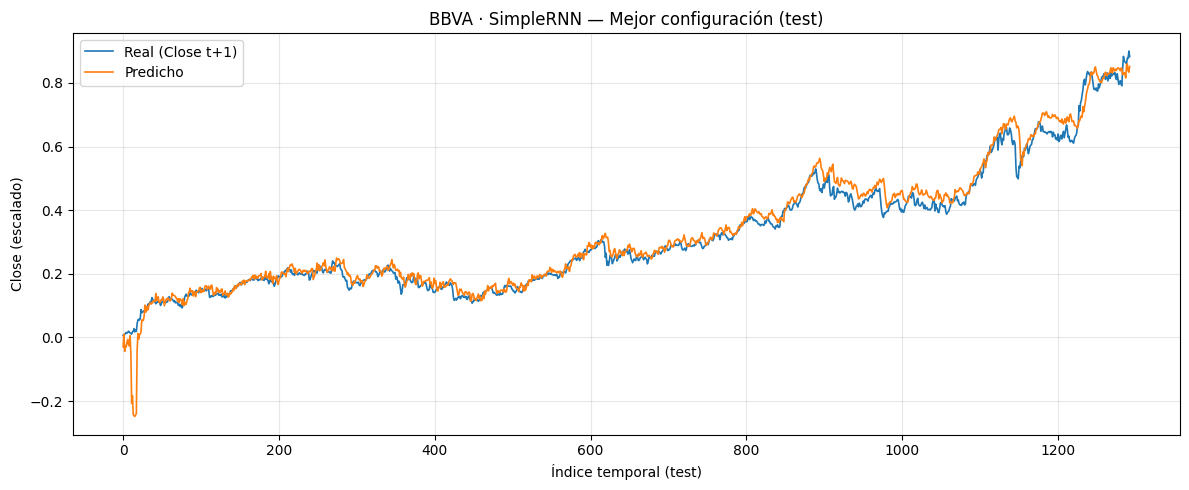

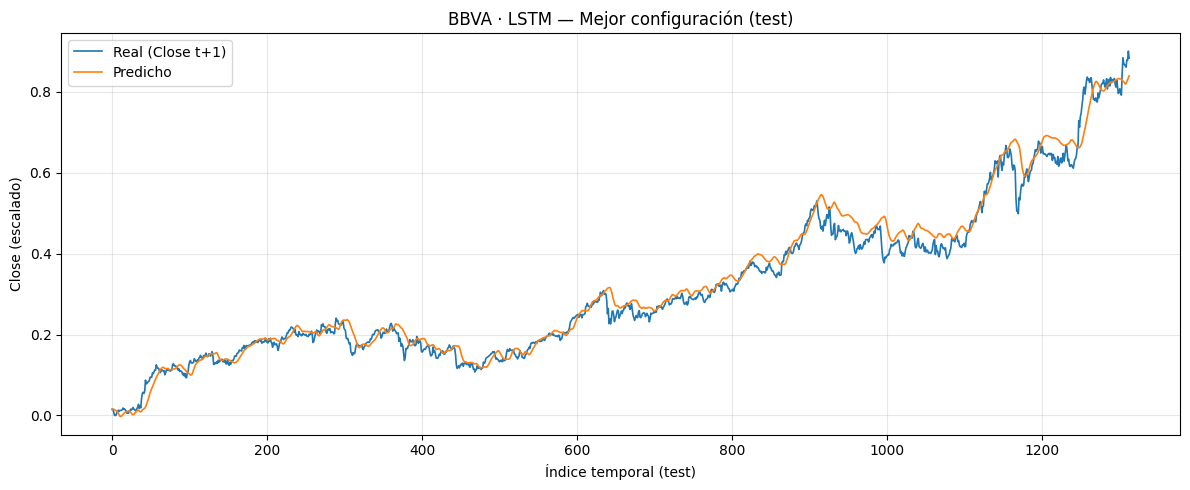

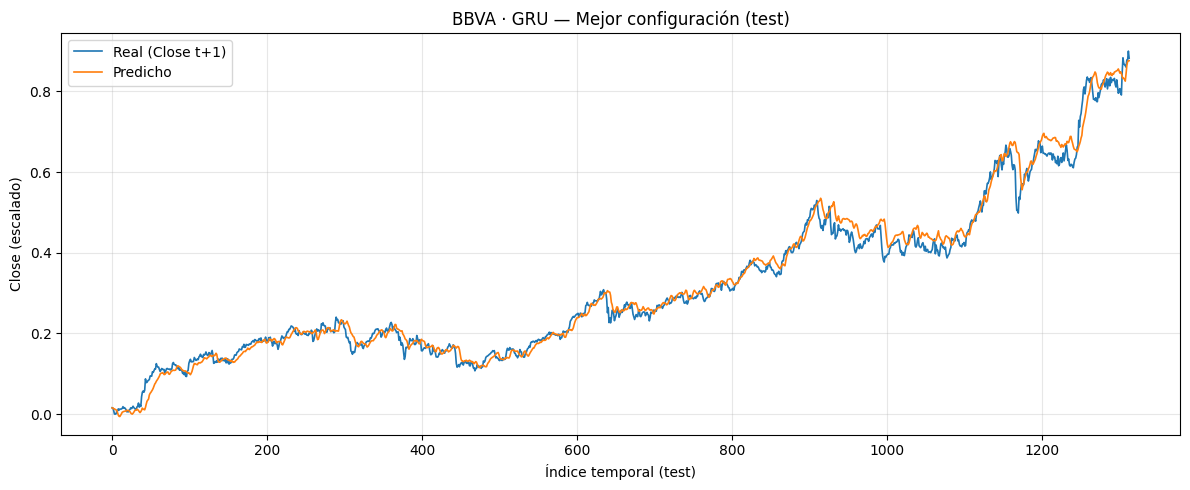

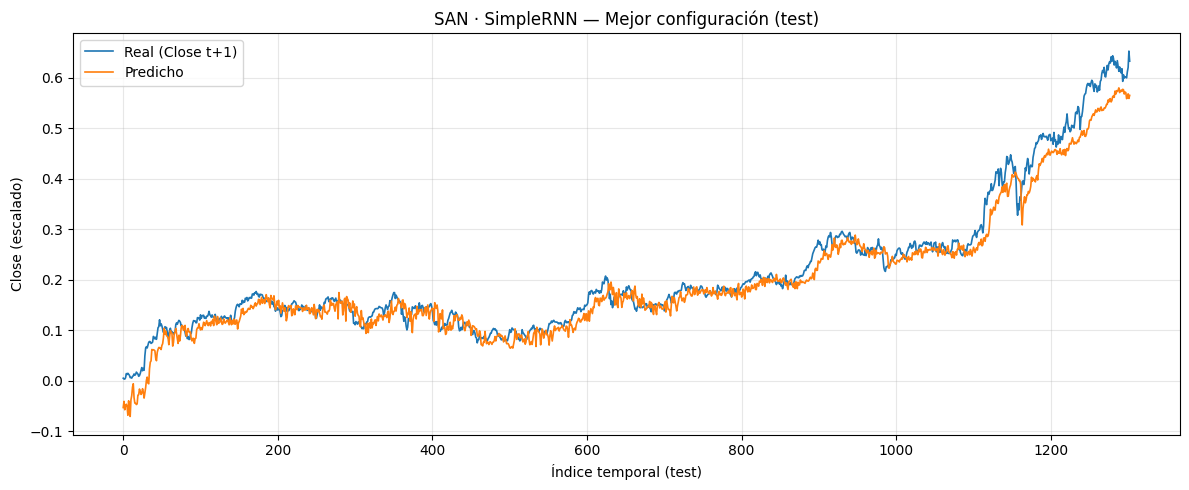

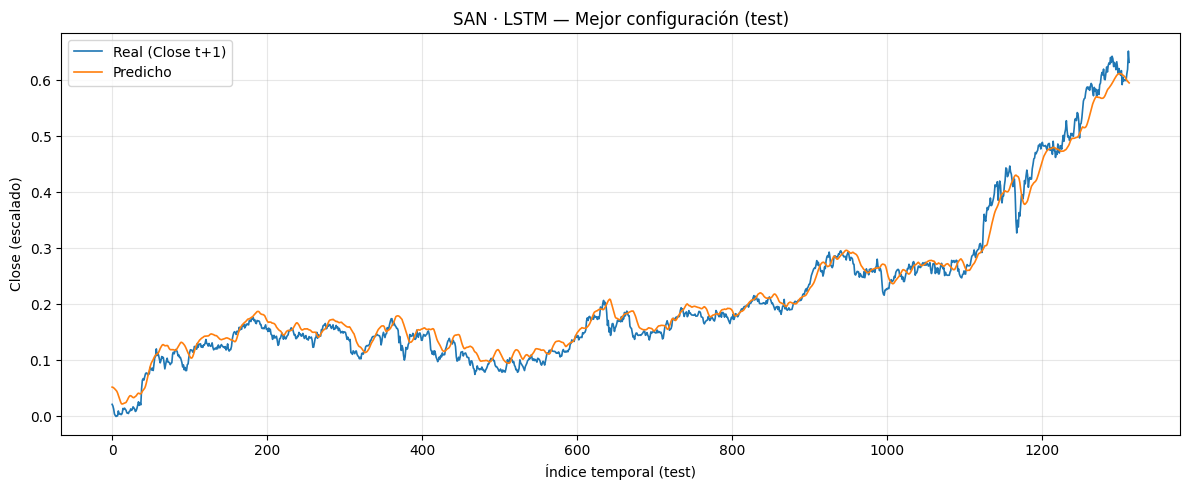

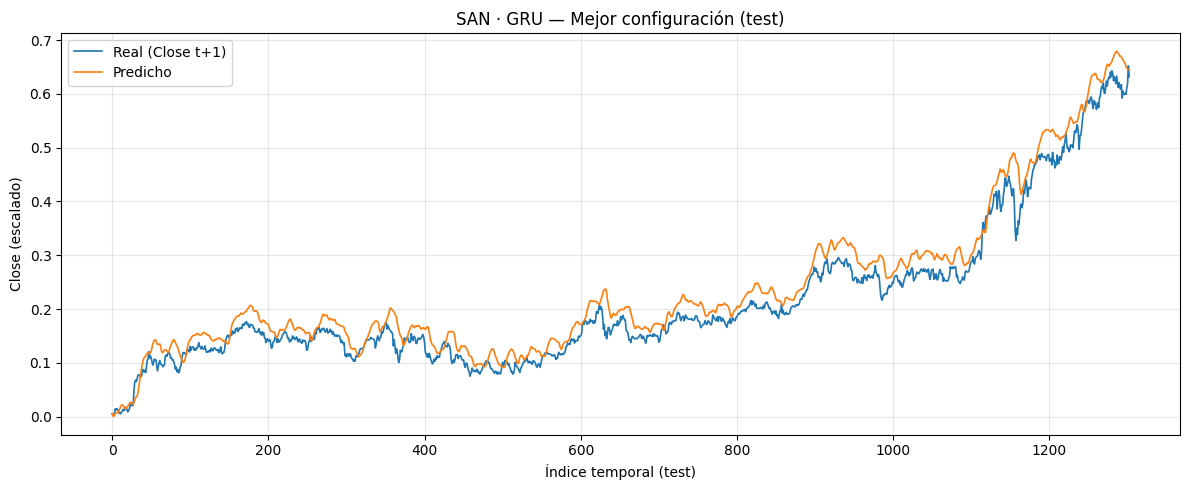

,ticker,model,window,units,batch,lr,val_mse,test_mse
2,BBVA,GRU,10,128,32,0.0005,0.000231,0.000616
1,BBVA,LSTM,10,128,32,0.0005,0.000279,0.000898
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000311,0.001174
4,SAN,LSTM,10,64,32,0.0010,0.000447,0.000442
3,SAN,SimpleRNN,20,32,64,0.0010,0.000431,0.000780
5,SAN,GRU,20,128,64,0.0005,0.000720,0.000968


In [22]:
def best_config(df: pd.DataFrame, tkr: str, m: str):
    sub = df[(df["ticker"]==tkr) & (df["model"]==m)].sort_values(["val_mse","test_mse"]).head(1).iloc[0]
    return dict(W=int(sub["window"]), U=int(sub["units"]), B=int(sub["batch"]), LR=float(sub["lr"]))

def plot_real_pred(y_true, y_pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Real (Close t+1)", linewidth=1.2)
    plt.plot(y_pred, label="Predicho", linewidth=1.2)
    plt.title(title); plt.xlabel("Índice temporal (test)"); plt.ylabel("Close (escalado)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

best_runs = []
for tkr in TICKERS:
    for m in MODELS:
        cfg = best_config(grid_all, tkr, m)
        # Entrenamos SOLO para graficar (pocas épocas por rapidez)
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, cfg["W"])
        model = build_model(m, cfg["U"], meta["n_features"], cfg["W"], cfg["LR"])
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(20, MAX_EPOCHS), batch_size=cfg["B"], verbose=0, callbacks=[es])
        yhat = model.predict(Xte, verbose=0).ravel()
        val_mse = float(np.mean((model.predict(Xva, verbose=0).ravel() - yva)**2))
        test_mse = float(np.mean((yhat - yte)**2))
        plot_real_pred(yte, yhat, f"{tkr} · {m} — Mejor configuración (test)")
        best_runs.append({
            "ticker": tkr, "model": m, "window": cfg["W"], "units": cfg["U"],
            "batch": cfg["B"], "lr": cfg["LR"], "val_mse": val_mse, "test_mse": test_mse
        })
        keras.backend.clear_session(); del model; gc.collect()

best_table = pd.DataFrame(best_runs).sort_values(["ticker","test_mse"])
best_table.to_csv(OUT_DIR / "best_models_summary.csv", index=False)
display(best_table)


In [45]:
def winner_by_ticker(best_table):
    out = []
    for tkr in sorted(best_table['ticker'].unique()):
        row = best_table[best_table['ticker']==tkr].sort_values('test_mse').iloc[0]
        out.append((tkr, row.model, int(row.window), int(row.units), int(row.batch), float(row.lr), float(row.test_mse)))
    return pd.DataFrame(out, columns=['ticker','model','window','units','batch','lr','test_mse'])

winner_by_ticker(best_table)


,ticker,model,window,units,batch,lr,test_mse
0,BBVA,GRU,10,128,32,0.0005,0.000654
1,SAN,GRU,20,128,64,0.0005,0.000057


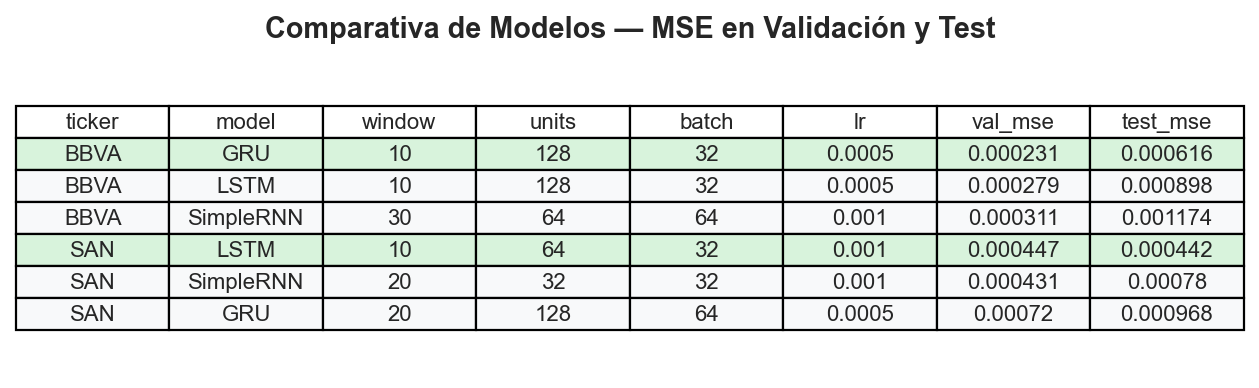

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# === Datos (tus resultados) ===
data = {
    "ticker": ["BBVA", "BBVA", "BBVA", "SAN", "SAN", "SAN"],
    "model": ["GRU", "LSTM", "SimpleRNN", "LSTM", "SimpleRNN", "GRU"],
    "window": [10, 10, 30, 10, 20, 20],
    "units": [128, 128, 64, 64, 32, 128],
    "batch": [32, 32, 64, 32, 32, 64],
    "lr": [0.0005, 0.0005, 0.001, 0.001, 0.001, 0.0005],
    "val_mse": [0.000231, 0.000279, 0.000311, 0.000447, 0.000431, 0.000720],
    "test_mse": [0.000616, 0.000898, 0.001174, 0.000442, 0.000780, 0.000968]
}

df = pd.DataFrame(data)

# === Crear figura ===
fig, ax = plt.subplots(figsize=(9, 2.5), dpi=160)
ax.axis("off")

# Colores base y destacados
base_color = "#f8f9fa"     # fondo general (blanco suave)
highlight_color = "#d8f3dc"  # verde suave para ganadores

# Crear color por fila (resalta ganadores)
row_colors = []
for _, row in df.iterrows():
    if (row["ticker"] == "BBVA" and row["model"] == "GRU") or \
       (row["ticker"] == "SAN" and row["model"] == "LSTM"):
        row_colors.append(highlight_color)
    else:
        row_colors.append(base_color)

# Crear tabla
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    cellColours=[[base_color]*len(df.columns)]*len(df)
)

# Aplicar colores a filas específicas
for i, color in enumerate(row_colors):
    for j in range(len(df.columns)):
        table[(i+1, j)].set_facecolor(color)

# Estilo general
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.2)

# Título
plt.title("Comparativa de Modelos — MSE en Validación y Test", fontsize=13, weight="bold", pad=12)
plt.show()


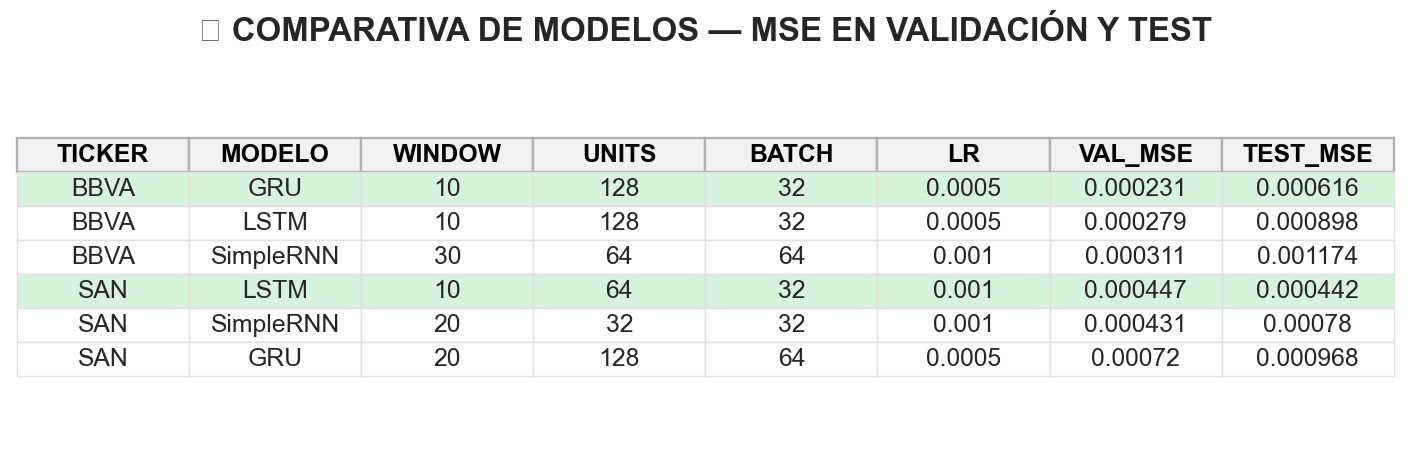

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# === Datos (tus resultados) ===
data = {
    "TICKER": ["BBVA", "BBVA", "BBVA", "SAN", "SAN", "SAN"],
    "MODELO": ["GRU", "LSTM", "SimpleRNN", "LSTM", "SimpleRNN", "GRU"],
    "WINDOW": [10, 10, 30, 10, 20, 20],
    "UNITS": [128, 128, 64, 64, 32, 128],
    "BATCH": [32, 32, 64, 32, 32, 64],
    "LR": [0.0005, 0.0005, 0.001, 0.001, 0.001, 0.0005],
    "VAL_MSE": [0.000231, 0.000279, 0.000311, 0.000447, 0.000431, 0.000720],
    "TEST_MSE": [0.000616, 0.000898, 0.001174, 0.000442, 0.000780, 0.000968]
}
df = pd.DataFrame(data)

# === Figura ===
fig, ax = plt.subplots(figsize=(9.5, 2.8), dpi=170)
ax.axis("off")

# Colores
base_color = "#ffffff"
highlight_color = "#d8f3dc"  # verde pastel para ganadores
header_color = "#f1f1f1"

# Identificar ganadores
row_colors = []
for _, row in df.iterrows():
    if (row["TICKER"] == "BBVA" and row["MODELO"] == "GRU") or \
       (row["TICKER"] == "SAN" and row["MODELO"] == "LSTM"):
        row_colors.append(highlight_color)
    else:
        row_colors.append(base_color)

# Crear tabla
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# === Estilo general ===
table.auto_set_font_size(False)
table.set_fontsize(10.5)
table.scale(1.1, 1.2)

# Fuente personalizada más estética
plt.rcParams['font.family'] = 'DejaVu Sans'

# Encabezados en mayúsculas y negrita
for j, col_name in enumerate(df.columns):
    cell = table[(0, j)]
    cell.set_text_props(weight='bold', color='black')
    cell.set_facecolor(header_color)

# Colorear filas ganadoras
for i, color in enumerate(row_colors):
    for j in range(len(df.columns)):
        table[(i+1, j)].set_facecolor(color)
        table[(i+1, j)].set_edgecolor("#e0e0e0")
        table[(i+1, j)].set_linewidth(0.6)

# Bordes encabezado
for j in range(len(df.columns)):
    table[(0, j)].set_edgecolor("#b0b0b0")
    table[(0, j)].set_linewidth(1)

# === Título ===
plt.title("📊 COMPARATIVA DE MODELOS — MSE EN VALIDACIÓN Y TEST", 
          fontsize=14, weight="bold", pad=14)
plt.show()


# Celda 12 — Mejora vs persistencia para los mejores

In [23]:
def mse(a,b): return float(np.mean((a-b)**2))

for row in best_table.itertuples(index=False):
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
    model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(30, MAX_EPOCHS), batch_size=int(row.batch), verbose=0, callbacks=[es])
    yhat = model.predict(Xte, verbose=0).ravel()
    ynaive = naive_persistence(Xte)
    mse_model = mse(yte, yhat)
    mse_naive = mse(yte, ynaive)
    imp = 100*(1 - mse_model/mse_naive)
    print(f"{row.ticker} · {row.model} (W={row.window}, U={row.units}) → MSE={mse_model:.6f} | Naive={mse_naive:.6f} | Mejora={imp:.2f}%")
    keras.backend.clear_session(); del model; gc.collect()


BBVA · GRU (W=10, U=128) → MSE=0.000545 | Naive=0.012939 | Mejora=95.79%
BBVA · LSTM (W=10, U=128) → MSE=0.000907 | Naive=0.012939 | Mejora=92.99%
BBVA · SimpleRNN (W=30, U=64) → MSE=0.000522 | Naive=0.012792 | Mejora=95.92%
SAN · LSTM (W=10, U=64) → MSE=0.000799 | Naive=0.018497 | Mejora=95.68%
SAN · SimpleRNN (W=20, U=32) → MSE=0.003337 | Naive=0.018460 | Mejora=81.93%
SAN · GRU (W=20, U=128) → MSE=0.000838 | Naive=0.018460 | Mejora=95.46%


# Celda 13 — Comparativa MSE (barras)

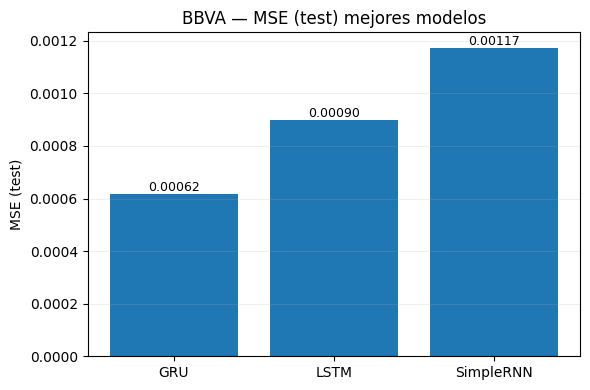

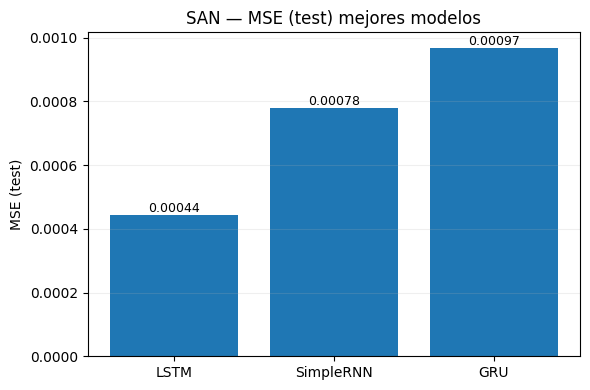

In [24]:
def bar_compare(best_table, ticker):
    sub = best_table[best_table["ticker"]==ticker].sort_values("test_mse")
    plt.figure(figsize=(6,4))
    plt.bar(sub["model"], sub["test_mse"])
    for i,(m,v) in enumerate(zip(sub["model"], sub["test_mse"])):
        plt.text(i, v, f"{v:.5f}", ha="center", va="bottom", fontsize=9)
    plt.title(f"{ticker} — MSE (test) mejores modelos")
    plt.ylabel("MSE (test)"); plt.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()

for tkr in TICKERS:
    bar_compare(best_table, tkr)


# Celda 14 — Guardar modelos .h5 (para Cuaderno 6)

In [25]:
SAVE_MODELS = True

if SAVE_MODELS:
    for row in best_table.itertuples(index=False):
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
        model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(30, MAX_EPOCHS), batch_size=int(row.batch), verbose=0, callbacks=[es])
        path = OUT_DIR / f"{row.ticker}_{row.model}_w{row.window}_u{row.units}_b{row.batch}_lr{row.lr}.h5"
        model.save(path)
        print("💾 Guardado:", path)
        keras.backend.clear_session(); del model; gc.collect()


💾 Guardado: ..\reports\models\BBVA_GRU_w10_u128_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\BBVA_LSTM_w10_u128_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\BBVA_SimpleRNN_w30_u64_b64_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_LSTM_w10_u64_b32_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_SimpleRNN_w20_u32_b64_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_GRU_w20_u128_b64_lr0.0005.h5


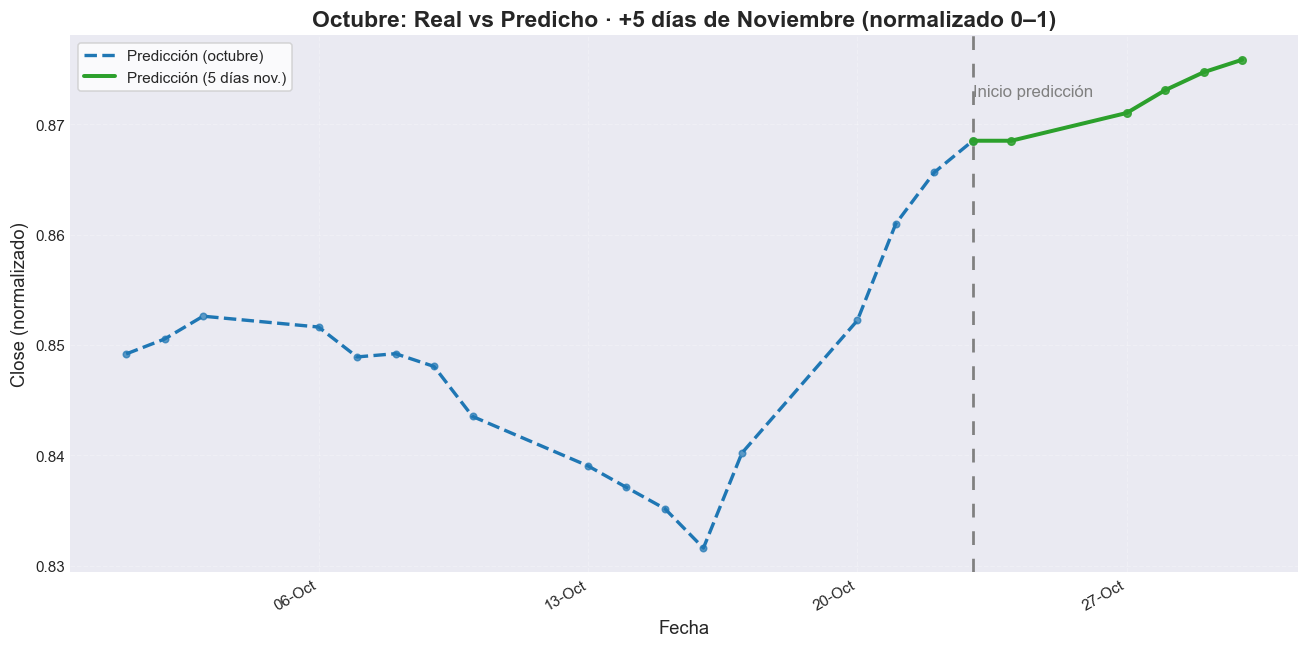

In [ ]:
# === Gráfica "bonita" con Matplotlib: Octubre (real vs predicho) + 5 días de noviembre (predicción) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- DataFrames a partir de tus arrays ---
df_real = pd.DataFrame({"Fecha": pd.to_datetime(idx_oct), "Valor": np.asarray(ytrue_oct, dtype=float)})
df_pred = pd.DataFrame({"Fecha": pd.to_datetime(idx_oct), "Valor": np.asarray(ypred_oct, dtype=float)})
df_futu = pd.DataFrame({"Fecha": pd.to_datetime(future_idx), "Valor": np.asarray(future_preds, dtype=float)})

# --- Unir la predicción futura con el último punto del predicho de octubre (evita salto visual) ---
last_pred_date = df_pred["Fecha"].max()
last_pred_val  = df_pred.loc[df_pred["Fecha"] == last_pred_date, "Valor"].values[0]
df_futu = pd.concat([
    pd.DataFrame({"Fecha": [last_pred_date], "Valor": [last_pred_val]}),
    df_futu
], ignore_index=True)

# --- Línea de división entre Octubre (histórico/predicho) y Noviembre (predicción futura) ---
div_line = last_pred_date

# --- Estilo Matplotlib "bonito" ---
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(12,6), dpi=110)

# Paleta

c_pred = "#1f77b4"   # naranja
c_futu = "#2ca02c"   # verde

# --- Trazados ---

# Predicho octubre
ax.plot(df_pred["Fecha"], df_pred["Valor"], color=c_pred, linewidth=2.2, linestyle="--", label="Predicción (octubre)")
ax.scatter(df_pred["Fecha"], df_pred["Valor"], color=c_pred, s=18, alpha=0.7)

# Predicción noviembre (unida al último punto de octubre)
ax.plot(df_futu["Fecha"], df_futu["Valor"], color=c_futu, linewidth=2.6, label="Predicción (5 días nov.)")
ax.scatter(df_futu["Fecha"], df_futu["Valor"], color=c_futu, s=24, alpha=0.85, zorder=3)

# Línea vertical de corte
ax.axvline(div_line, color="gray", linewidth=1.8, linestyle=(0,(5,5)))
ax.text(div_line, ax.get_ylim()[1]*0.995, "Inicio predicción",
        ha="left", va="top", fontsize=11, color="gray")

# --- Formato de ejes y títulos ---
ax.set_title("Octubre · +5 días de Noviembre (normalizado 0–1)", fontsize=15, weight="bold")
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Close (normalizado)", fontsize=12)

# Formato de fechas (diarias)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))   # ticks semanales (lunes)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.autofmt_xdate()

# Leyenda y estética
ax.legend(loc="upper left", frameon=True, facecolor="white", framealpha=0.8)
ax.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


In [42]:
# === Cargar modelos .h5 (legacy) en Keras 3: compile=False + recompilar ===
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

# Localiza la carpeta de modelos
CANDIDATES = [Path("../reports/models"), Path("./reports/models"), Path("reports/models")]
for c in CANDIDATES:
    if c.exists():
        MODELS_DIR = c
        break
else:
    raise FileNotFoundError("No encuentro 'reports/models'.")

print("📁 Modelos en:", MODELS_DIR.resolve())

def load_legacy_h5(pattern: str, optimizer="adam", lr=1e-3):
    files = sorted(MODELS_DIR.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No hay ficheros que cumplan '{pattern}' en {MODELS_DIR}")
    path = files[0]
    print(f"✅ Cargando (legacy .h5, compile=False): {path.name}")
    # Cargar sin compilar para evitar el error de deserialización
    model = keras.models.load_model(path, compile=False)
    # Recompilar de forma explícita (igual que entrenabas: Adam + MSE)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse", metrics=["mse"])
    return model

# === Carga tus dos modelos concretos ===
model_bbva = load_legacy_h5("BBVA_GRU_w10_u128_b32_lr0.0005.h5", lr=0.0005)
model_san  = load_legacy_h5("SAN_LSTM_w10_u64_b32_lr0.001.h5",   lr=0.001)

print("✅ Modelos listos.")


📁 Modelos en: D:\proyectos\Caso02_Predicciones_bancos\reports\models
✅ Cargando (legacy .h5, compile=False): BBVA_GRU_w10_u128_b32_lr0.0005.h5
✅ Cargando (legacy .h5, compile=False): SAN_LSTM_w10_u64_b32_lr0.001.h5
✅ Modelos listos.


In [43]:
# === Gráfica BBVA (predicho octubre + 5 días de nov) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# >>> Asegúrate de tener creadas estas variables antes:
# idx_oct_bbva, ypred_oct_bbva, future_idx_bbva, future_preds_bbva

# --- DataFrames a partir de tus arrays ---
df_pred = pd.DataFrame({"Fecha": pd.to_datetime(idx_oct_bbva),
                        "Valor": np.asarray(ypred_oct_bbva, dtype=float)})
df_futu = pd.DataFrame({"Fecha": pd.to_datetime(future_idx_bbva),
                        "Valor": np.asarray(future_preds_bbva, dtype=float)})

# --- Unir el último punto de octubre con la predicción de nov ---
last_pred_date = df_pred["Fecha"].max()
last_pred_val  = df_pred.loc[df_pred["Fecha"] == last_pred_date, "Valor"].values[0]
df_futu = pd.concat([
    pd.DataFrame({"Fecha": [last_pred_date], "Valor": [last_pred_val]}),
    df_futu
], ignore_index=True)

div_line = last_pred_date  # línea vertical

# --- Estilo Matplotlib ---
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(12,6), dpi=110)

c_pred = "#1f77b4"   # azul para octubre (predicho)
c_futu = "#2ca02c"   # verde para nov (predicción)

# Octubre (predicho)
ax.plot(df_pred["Fecha"], df_pred["Valor"], color=c_pred, linewidth=2.2,
        linestyle="--", label="Predicción (octubre)")
ax.scatter(df_pred["Fecha"], df_pred["Valor"], color=c_pred, s=18, alpha=0.7)

# Noviembre (predicción unida)
ax.plot(df_futu["Fecha"], df_futu["Valor"], color=c_futu, linewidth=2.6,
        label="Predicción (5 días nov.)")
ax.scatter(df_futu["Fecha"], df_futu["Valor"], color=c_futu, s=24, alpha=0.85, zorder=3)

# Línea vertical de corte
ax.axvline(div_line, color="gray", linewidth=1.8, linestyle=(0,(5,5)))
ax.text(div_line, ax.get_ylim()[1]*0.995, "Inicio predicción",
        ha="left", va="top", fontsize=11, color="gray")

# Ejes y título
ax.set_title("BBVA — Octubre · +5 días de Noviembre (normalizado 0–1)", fontsize=15, weight="bold")
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Close (normalizado)", fontsize=12)

# Fechas
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.autofmt_xdate()

ax.legend(loc="upper left", frameon=True, facecolor="white", framealpha=0.8)
ax.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()

# (Opcional) Guardar para Streamlit
# fig.savefig("bbva_oct_nov_pred.png", dpi=140, bbox_inches="tight")


NameError: name 'future_idx_bbva' is not defined

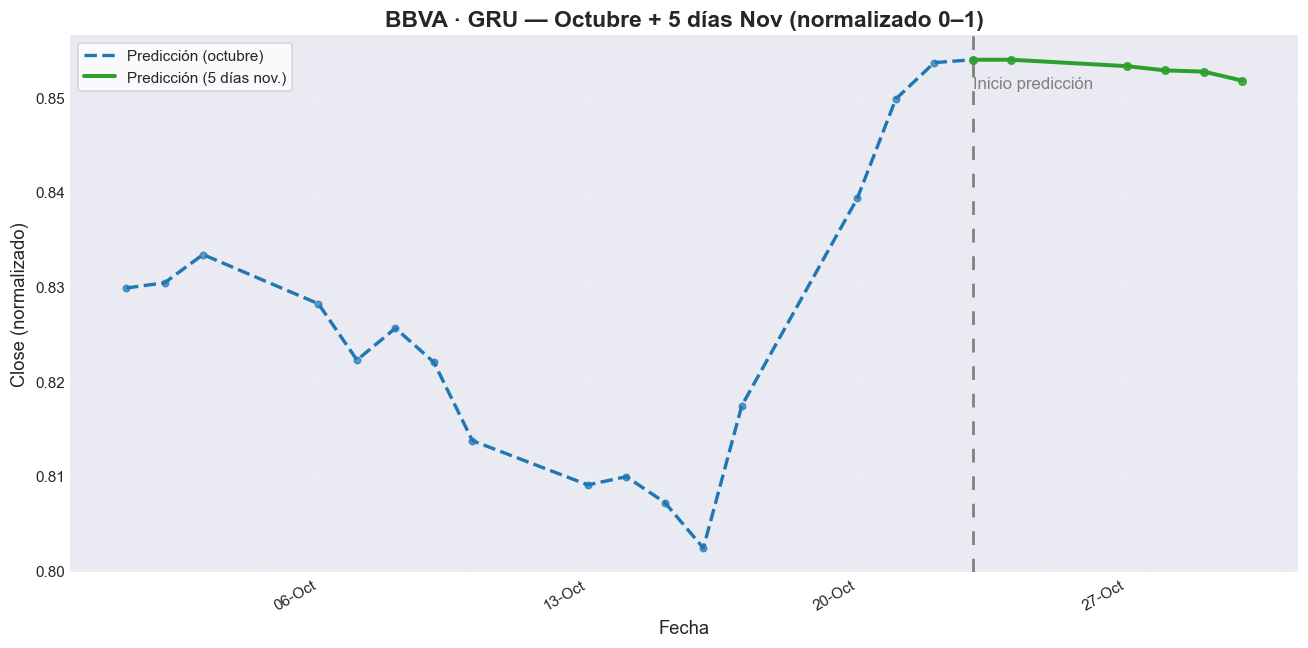

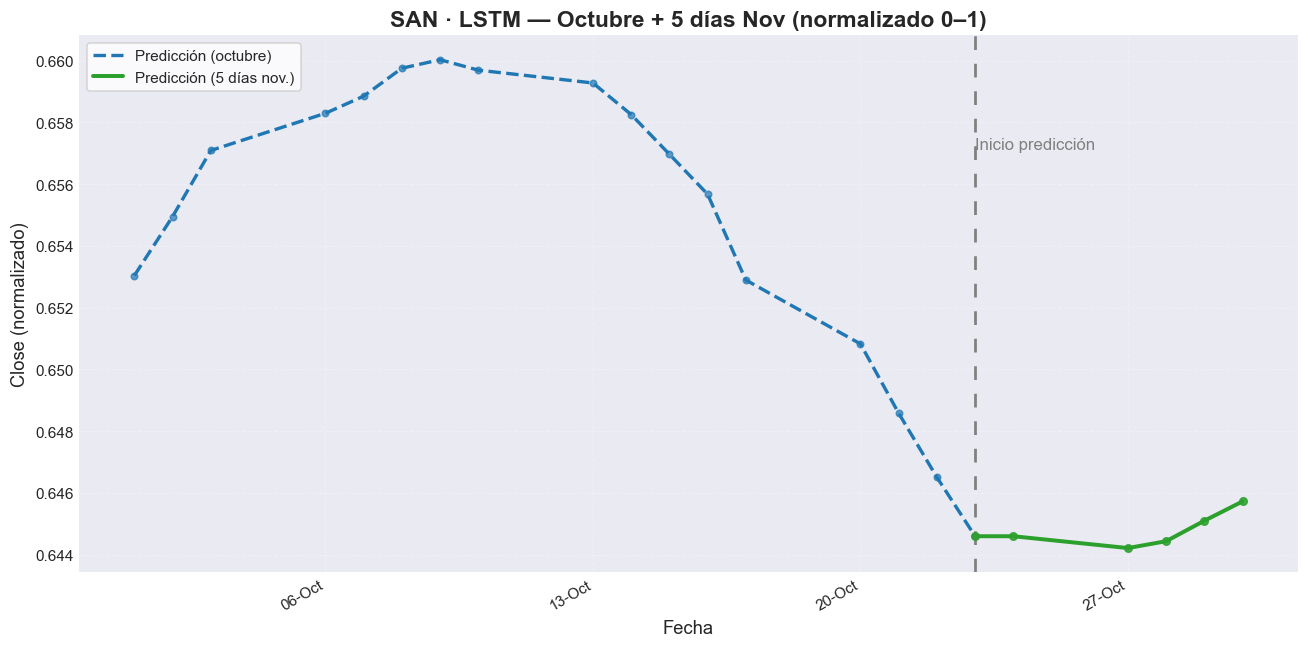

In [51]:
# === Generar OCTUBRE + 5 días NOV y dibujar 2 gráficas (BBVA y SAN) ===
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow import keras  # ya tienes model_bbva y model_san cargados

# ----- Localización de datos -----
CANDIDATES = [Path("./data/processed/seq"), Path("../data/processed/seq")]
for c in CANDIDATES:
    if c.exists():
        DATA_DIR = c
        break
else:
    raise FileNotFoundError("No encuentro ./data/processed/seq ni ../data/processed/seq")

# ----- Utilidades de carga -----
def load_seq_arrays(tkr: str, W: int):
    base = DATA_DIR / tkr / f"w{W}"
    Xte = np.load(base/"X_test.npy")
    # idx_test.csv a veces tiene cabecera 'date' y a veces no: hazlo robusto
    idx_df = pd.read_csv(base/"idx_test.csv")
    if "date" in idx_df.columns:
        idx_te = pd.to_datetime(idx_df["date"])
    else:
        idx_te = pd.to_datetime(idx_df.iloc[:,0])
    return Xte, idx_te

def last_october_mask(idx: pd.Series) -> pd.Series:
    """Máscara booleana del último octubre disponible en el índice."""
    months = idx.dt.month
    years  = idx.dt.year
    if not (months==10).any():
        raise ValueError("No hay datos de octubre en idx_test.")
    last_year = years[months==10].max()
    return (months==10) & (years==last_year)

def recursive_future_preds(model, last_window: np.ndarray, steps: int = 5) -> np.ndarray:
    """
    Predicción recursiva: usa la última ventana (shape: [W, n_features]).
    Para cada paso: predice y_t+1 y actualiza solo la feature 0 (Close) del último timestep.
    Mantiene el resto de features con los últimos valores (estrategia estable y simple).
    """
    x = last_window.copy()
    fut = []
    for _ in range(steps):
        yhat = model.predict(x[np.newaxis, ...], verbose=0).ravel()[0]
        fut.append(yhat)
        # shift ventana y mete el nuevo 'Close' predicho en la última fila
        x[:-1] = x[1:]
        x[-1, 0] = yhat
        # el resto de features de la última fila se dejan tal cual (persistencia)
    return np.array(fut, dtype=float)

def build_october_and_future(tkr: str, model, W: int):
    """
    Devuelve:
      idx_oct, ypred_oct, future_idx, future_preds
    todo en NORMALIZADO (0-1), listos para graficar.
    """
    Xte, idx_te = load_seq_arrays(tkr, W)

    # Predicciones para todo TEST (normalizado)
    ypred_test = model.predict(Xte, verbose=0).ravel()

    # Filtra el último octubre
    m = last_october_mask(idx_te)
    idx_oct = pd.to_datetime(idx_te[m]).reset_index(drop=True)
    ypred_oct = ypred_test[m]

    # Toma la última ventana de OCTUBRE para arrancar la recursiva
    # Buscamos el último índice (posición) de idx_te que esté en idx_oct.max()
    last_oct_date = idx_oct.iloc[-1]
    pos = int(np.where(idx_te.values == last_oct_date.to_datetime64())[0][-1])
    last_window = Xte[pos]  # ventana que produjo la predicción de ese t+1

    # Fechas futuras: 5 días laborables a partir del siguiente día hábil
    # (si el last_oct_date es un viernes, irá a lunes, etc.)
    future_idx = pd.bdate_range(last_oct_date + pd.Timedelta(days=1), periods=5)

    # Predicción recursiva 5 pasos
    future_preds = recursive_future_preds(model, last_window, steps=5)

    return idx_oct, ypred_oct, future_idx, future_preds

# ====== Construir variables para ambos bancos ======
# BBVA: por el nombre del modelo, W=10
idx_oct_bbva, ypred_oct_bbva, future_idx_bbva, future_preds_bbva = build_october_and_future("BBVA", model_bbva, W=10)

# SAN: por el nombre del modelo, W=10
idx_oct_san, ypred_oct_san, future_idx_san, future_preds_san = build_october_and_future("SAN", model_san, W=10)

# ====== Función de gráfico “bonito” (MISMO estilo que ya te funcionaba) ======
def plot_pred_vs_future(title: str, idx_oct, ypred_oct, future_idx, future_preds,
                        c_pred="#1f77b4", c_futu="#2ca02c"):
    # --- DataFrames ---
    df_pred = pd.DataFrame({"Fecha": pd.to_datetime(idx_oct),
                            "Valor": np.asarray(ypred_oct, dtype=float)})
    df_futu = pd.DataFrame({"Fecha": pd.to_datetime(future_idx),
                            "Valor": np.asarray(future_preds, dtype=float)})

    # Unir el último punto de octubre con el primero de nov (para continuidad visual)
    last_pred_date = df_pred["Fecha"].max()
    last_pred_val  = df_pred.loc[df_pred["Fecha"] == last_pred_date, "Valor"].values[0]
    df_futu = pd.concat([
        pd.DataFrame({"Fecha": [last_pred_date], "Valor": [last_pred_val]}),
        df_futu
    ], ignore_index=True)

    # Estilo y figura
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, ax = plt.subplots(figsize=(12,6), dpi=110)

    # Series
    ax.plot(df_pred["Fecha"], df_pred["Valor"], color=c_pred, linewidth=2.2,
            linestyle="--", label="Predicción (octubre)")
    ax.scatter(df_pred["Fecha"], df_pred["Valor"], color=c_pred, s=18, alpha=0.7)
    ax.plot(df_futu["Fecha"], df_futu["Valor"], color=c_futu, linewidth=2.6,
            label="Predicción (5 días nov.)")
    ax.scatter(df_futu["Fecha"], df_futu["Valor"], color=c_futu, s=24, alpha=0.85, zorder=3)

    # Línea vertical de corte
    ax.axvline(last_pred_date, color="gray", linewidth=1.8, linestyle=(0,(5,5)))
    ax.text(last_pred_date, ax.get_ylim()[1]*0.995, "Inicio predicción",
            ha="left", va="top", fontsize=11, color="gray")

    # Ejes
    ax.set_title(title + " (normalizado 0–1)", fontsize=15, weight="bold")
    ax.set_xlabel("Fecha", fontsize=12)
    ax.set_ylabel("Close (normalizado)", fontsize=12)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    fig.autofmt_xdate()

    ax.legend(loc="upper left", frameon=True, facecolor="white", framealpha=0.8)
    ax.grid(True, linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

# ====== DIBUJAR dos gráficas separadas ======
plot_pred_vs_future("BBVA · GRU — Octubre + 5 días Nov", idx_oct_bbva, ypred_oct_bbva,
                    future_idx_bbva, future_preds_bbva)

plot_pred_vs_future("SAN · LSTM — Octubre + 5 días Nov", idx_oct_san, ypred_oct_san,
                    future_idx_san, future_preds_san)


In [53]:
# === Celda: Exportar predicciones para la app (desde secuencias) ===
from pathlib import Path
import numpy as np, pandas as pd
from datetime import date

W = 10  # según tu cuaderno (modelos con w10)
OUT_CSV = Path("../data/app/predicciones.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# --- carga de arrays ---
def load_seq_arrays(tkr: str, W: int, base_dir=Path("../data/processed/seq")):
    base = base_dir / tkr / f"w{W}"
    Xte = np.load(base/"X_test.npy")
    idx_df = pd.read_csv(base/"idx_test.csv")
    idx_te = pd.to_datetime(idx_df["date"] if "date" in idx_df.columns else idx_df.iloc[:,0])
    return Xte, idx_te

# --- predicción recursiva ---
def recursive_future_preds(model, last_window: np.ndarray, steps: int = 10):
    x = last_window.copy()
    fut = []
    for _ in range(steps):
        yhat = model.predict(x[np.newaxis, ...], verbose=0).ravel()[0]
        fut.append(yhat)
        x[:-1] = x[1:]
        x[-1, 0] = yhat
    return np.array(fut, dtype=float)

# --- carga del CSV real en euros ---
def load_price_csv_real(path: Path) -> pd.DataFrame:
    header_idx = 0
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if line.strip().lower().startswith("date"):
                header_idx = i
                break
    cols = ["date","price","adj_close","close","dividends","high","low","open","stock_splits","volume"]
    df = pd.read_csv(path, header=None, names=cols, skiprows=header_idx+1)
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
    close = pd.to_numeric(df["adj_close"], errors="coerce") if df["adj_close"].notna().any() \
            else pd.to_numeric(df["close"], errors="coerce")
    out = pd.DataFrame({"date": df["date"], "close": close}).dropna()
    return out.sort_values("date").reset_index(drop=True)

# 🔹 CAMBIO AQUÍ: tus CSV están directamente en data/
bbva_real = load_price_csv_real(Path("../data/BBVA.csv"))
san_real  = load_price_csv_real(Path("../data/SANTANDER.csv"))

# --- construir DataFrame de predicciones ---
def export_from_seq_for_ticker(tkr: str, model, df_real: pd.DataFrame, W: int) -> pd.DataFrame:
    Xte, idx_te = load_seq_arrays(tkr, W)
    y_pred_norm = model.predict(Xte, verbose=0).ravel()

    real_map = pd.Series(df_real["close"].values, index=pd.to_datetime(df_real["date"]))
    y_true_eur = real_map.reindex(idx_te).values

    rmin, rmax = np.nanmin(df_real["close"].values), np.nanmax(df_real["close"].values)
    y_pred_eur = rmin + (rmax - rmin) * np.asarray(y_pred_norm, dtype=float)

    df_test = pd.DataFrame({
        "date": idx_te.dt.date,
        "ticker": tkr,
        "y_true": y_true_eur,
        "y_pred": y_pred_eur
    })

    # Forecast 1–10 nov
    future_dates = pd.date_range("2025-11-01", "2025-11-10", freq="D")
    last_window = Xte[-1]
    fut_norm = recursive_future_preds(model, last_window, steps=len(future_dates))
    fut_eur = rmin + (rmax - rmin) * fut_norm

    df_fore = pd.DataFrame({
        "date": future_dates.date,
        "ticker": tkr,
        "y_true": np.nan,
        "y_pred": fut_eur
    })

    return pd.concat([df_test, df_fore], ignore_index=True)

# --- generar predicciones para ambos bancos ---
pred_bbva = export_from_seq_for_ticker("BBVA", model_bbva, bbva_real, W)
pred_san  = export_from_seq_for_ticker("SAN",  model_san,  san_real,  W)

pred_all = pd.concat([pred_bbva, pred_san], ignore_index=True)
pred_all = pred_all.sort_values(["ticker","date"])
pred_all.to_csv(OUT_CSV, index=False, float_format="%.6f")

print(f"✅ Exportado correctamente: {OUT_CSV.resolve()}")
pred_all.tail(10)


✅ Exportado correctamente: D:\proyectos\Caso02_Predicciones_bancos\data\app\predicciones.csv


,date,ticker,y_true,y_pred
2636,2025-11-01,SAN,NaN,8.892208
2637,2025-11-02,SAN,NaN,8.887800
2638,2025-11-03,SAN,NaN,8.890360
2639,2025-11-04,SAN,NaN,8.897991
2640,2025-11-05,SAN,NaN,8.905188
2641,2025-11-06,SAN,NaN,8.914102
2642,2025-11-07,SAN,NaN,8.928679
2643,2025-11-08,SAN,NaN,8.937349
2644,2025-11-09,SAN,NaN,8.944707
2645,2025-11-10,SAN,NaN,8.949648
